# Data Exploration

Here we perform some preliminary data analyses and formulate our questions and hypotheses at the end.

In [1]:
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from vaderSentiment import vaderSentiment

### What tables are in our database?

In [2]:
db_path = 'postgres:///music'
engine = create_engine(db_path)

table_names = engine.table_names()
table_names

['reviews', 'artists', 'genres', 'labels', 'years', 'content']

In [3]:
def postgres_to_df(table):
    """Return a Pandas DataFrame generated from an PostgreSQL table."""
    engine = create_engine(db_path)
    conn = engine.connect()
    result = conn.execute(f'SELECT * FROM {table}')
    columns = [x for x in result.keys()]
    df = pd.DataFrame(result.fetchall(),columns=columns)
    return df

### What information is available in these tables for further analysis?

In [4]:
for table_name in table_names:
    print(table_name.upper(), postgres_to_df(table_name).columns, '\n', sep='\n')

REVIEWS
Index(['reviewid', 'title', 'artist', 'url', 'score', 'best_new_music',
       'author', 'author_type', 'pub_date', 'pub_weekday', 'pub_day',
       'pub_month', 'pub_year'],
      dtype='object')


ARTISTS
Index(['reviewid', 'artist'], dtype='object')


GENRES
Index(['reviewid', 'genre'], dtype='object')


LABELS
Index(['reviewid', 'label'], dtype='object')


YEARS
Index(['reviewid', 'year'], dtype='object')


CONTENT
Index(['reviewid', 'content'], dtype='object')




In [5]:
reviews = postgres_to_df('reviews')
reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


### Lets dig in and ask a few questions.

In [6]:
len(reviews), reviews['artist'].nunique()

(18393, 8715)

In [7]:
labels = postgres_to_df('labels')
len(labels), labels['label'].nunique()

(20190, 3667)

In [8]:
content = postgres_to_df('content')
content.head() 

query = """
SELECT
    reviews.score,
    reviews.reviewid,
    reviews.pub_year,
    content.content
FROM reviews 
FULL OUTER JOIN content ON reviews.reviewid = content.reviewid
ORDER BY reviews.pub_year
"""
engine = create_engine(db_path)
conn = engine.connect()
result = conn.execute(query)
content = pd.DataFrame(result.fetchall(), columns=result.keys())
content.head()

,score,reviewid,pub_year,content
0,5.5,3183,1999,"By all rights, when a critical assessment of t..."
1,9.0,5041,1999,There's only one question that really needs to...
2,6.0,8718,1999,Miles Duchamp\n 43-A Pettybone Way\n Ess...
3,6.3,4718,1999,Leftfield are surely dance music's most reluct...
4,3.8,5383,1999,Marilyn Vos Savant may have the highest record...


In [9]:
content['content'][0][:300]

"By all rights, when a critical assessment of this musical decade is made,\n    the influence of country on its more popular cousin, rock, will have to be\n    reckoned with.  Sure, country- rock rambled about long before the '90s\n    first messed its pants, and certainly the Eagles enjoyed more fame a"

In [10]:
sent_analyzer = vaderSentiment.SentimentIntensityAnalyzer()
sentiments = [sent_analyzer.polarity_scores(text)['compound'] for text in content['content'][:100]]
len(sentiments), type(sentiments)

(100, list)

In [11]:
sentiments[:10]

[0.9969,
 0.9964,
 0.9989,
 -0.8316,
 0.9545,
 0.9723,
 0.9934,
 0.9927,
 0.9988,
 0.7084]

### How do review score and review sentiment correlate? Apparently quite poorly, most likely due to use of flavorful and descriptive language.

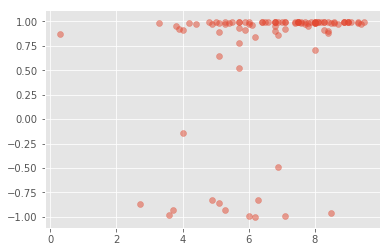

In [12]:
plt.scatter(content['score'][:100], sentiments, alpha=0.5);

In [13]:
query = """
SELECT
    reviews.score,
    reviews.reviewid,
    reviews.pub_year,
    years.year
FROM reviews 
FULL OUTER JOIN years ON reviews.reviewid = years.reviewid
ORDER BY years.year
"""
engine = create_engine(db_path)
conn = engine.connect()
result = conn.execute(query)
df = pd.DataFrame(result.fetchall(), columns=result.keys())
df.head()

,score,reviewid,pub_year,year
0,8.2,13258,2009,1959.0
1,9.0,21797,2016,1960.0
2,8.3,17864,2013,1960.0
3,9.4,1544,2002,1960.0
4,8.6,21098,2015,1962.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19116 entries, 0 to 19115
Data columns (total 4 columns):
score       19116 non-null float64
reviewid    19116 non-null int64
pub_year    19116 non-null int64
year        18710 non-null float64
dtypes: float64(2), int64(2)
memory usage: 597.5 KB


In [15]:
df.dropna(inplace=True)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


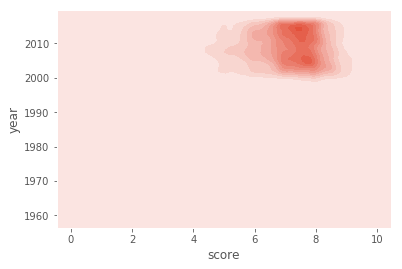

In [16]:
sns.kdeplot(df['score'], df['year'], shade=True);

In [17]:
years = []
for year in df['year'].unique():
    years.append(df[df['year'] == year])
    
years[50].head()

,score,reviewid,pub_year,year
10559,8.6,14999,2011,2010.0
10560,7.4,15087,2011,2010.0
10561,7.9,15080,2011,2010.0
10562,6.0,15074,2011,2010.0
10563,7.2,13800,2010,2010.0


In [18]:
mean_scores_years = []
for year in years:
    mean_scores_years.append(year['score'].mean())

### Has music gotten worse over time? 

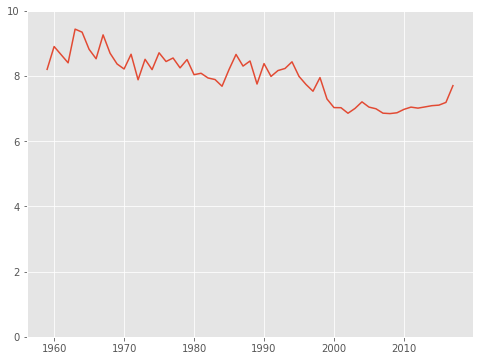

In [19]:
years = list(map(float, df['year'].unique()))
plt.figure(figsize=(8, 6))
plt.ylim(0, 10)
plt.plot(years, mean_scores_years);

# Is there a statistically significant difference between the scores of albums in the jazz and metal genres?

$H_o$: Jazz albums have the same average score as metal albums. 

$H_a$: Jazz albums do not have the same average score as metal albums.

# Will the label with the most artists have the highest album scores?

$H_o$: The label with the most artists signed will have the same average score as the label with the least artists signed.

$H_a$: The label with the most artists signed will not have the same average score as the label with the least artists signed.

# Is there a relationship between labels' genre diversity and labels' average score?

$H_o$: The label with the most genre diversity will not have a higher average score than the label with the least genre diversity.

$H_a$: The label with the most genre diversity will have a higher average score than the label with the least genre diversity.

# Are the average album scores of 2000-2009 different from those of 2010-2017?

$H_o$: Average song scores are the same in both periods.

$H_a$: Average song scores have changed in the more recent period.

# Conclusions can be found in the README. Conclusions with detailed hypothesis testing can also be found in the four notebooks of these four respective questions.